## Notebook setup

In [1]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd

from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [2]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [3]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "TRTN"

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]
exchange = "NYSE"
report_name = f"{symbol}".upper()

# Customize 
similar_companies_dict={
                        'AM' : ['EPD','ET','ENB','PBA','MPLX'],
                        'AR': ['RRC', 'EQT','SWN','CNX','CHK'],
                        'FLNG' : ['GLNG','SFL'],
                        'FTCO': ['GOLD','KGC','AU','AEM','NEM'],
                        'GSL' : ['DAC','CMRE','SFL'],
                        'MP' : ['SGML','LAC','MTRN'],
                        'INSW' : ['FRO','TRMD','EURN'],
                        'IBM' : ['MSFT','GOOGL','INTC','HPQ','AAPL'],
                        'MPLX' : ['AM','EPD','ENB','PBA','ET'],
                        'TRTN' : ['TGH','AER','GATX'],
                        'KNTK' : ['AM','EPD','ENB','PBA','ET','MPLX'],
                        'V' : ['MA','PYPL','SQ','EBAY','FIS'],
                        'ZIM' : ['MATX']
                        }


investor_report_url_dict ={'TRTN': 'https://www.tritoninternational.com/sites/triton-corp/files/investor-presentation-nov-2022.pdf',
                            'GSL': 'https://www.globalshiplease.com/static-files/a226750c-bb27-45e2-8017-a0183e07ad26', 
                            'MP' : 'https://s25.q4cdn.com/570172628/files/doc_presentations/2022/11/MP-3Q22-Earnings-Deck-FINAL.pdf',
                           'TMDX': 'https://investors.transmedics.com/static-files/c4f69c45-77b0-4981-a5a7-b404ab4aae95',
                            'AR' : 'https://d1io3yog0oux5.cloudfront.net/_6cc4d707f40f7cc56aebe36b019cb270/anteroresources/db/641/5970/pdf/AR+Investor+Presentation_Dec_12.01.2022_vF3.pdf'}

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""
 

In [4]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [5]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for TRTN with starting period 2021-08-06.

('Investment Research Report on TRTN',
 '28 January, 2023',
 '13:41',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [6]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,4,2,2,4,1
Average Estimate,425 USD,411 USD,413 USD,"1,661 USD","1,671 USD"
Year Ago,417 USD,417 USD,422 USD,-,"1,661 USD"
Publish Date,2/14/2023,5/2/2023,7/27/2023,-,-


In [7]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)

In [8]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

5 news articles for  Triton International Limited were found since 2023-01-21

In [9]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",7.883 M,2022-09-29,13.40 %,555.329 M
2,Dimensional Fund Advisors LP,4.507 M,2022-09-29,7.66 %,317.498 M
3,Blackrock Inc.,4.224 M,2022-09-29,7.18 %,297.591 M
4,"Goodnow Investment Group, LLC",2.121 M,2022-09-29,3.61 %,149.445 M
5,Lsv Asset Management,1.696 M,2022-09-29,2.88 %,119.481 M
6,State Street Corporation,1.424 M,2022-09-29,2.42 %,100.348 M
7,"Geode Capital Management, LLC",1.089 M,2022-09-29,1.85 %,76.737 M
8,Northern Trust Corporation,872.074 K,2022-09-29,1.48 %,61.438 M
9,"Charles Schwab Investment Management, Inc.",717.226 K,2022-09-29,1.22 %,50.529 M
10,Norges Bank Investment Management,674.767 K,2021-12-30,1.15 %,47.537 M


In [10]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,"Vanguard Group, Inc. (The)",7.883 M,2022-09-29,13.40 %,555.329 M
1,Dimensional Fund Advisors LP,4.507 M,2022-09-29,7.66 %,317.498 M
2,Blackrock Inc.,4.224 M,2022-09-29,7.18 %,297.591 M
3,"Goodnow Investment Group, LLC",2.121 M,2022-09-29,3.61 %,149.445 M
4,Lsv Asset Management,1.696 M,2022-09-29,2.88 %,119.481 M
5,State Street Corporation,1.424 M,2022-09-29,2.42 %,100.348 M
6,"Geode Capital Management, LLC",1.089 M,2022-09-29,1.85 %,76.737 M
7,Northern Trust Corporation,872.074 K,2022-09-29,1.48 %,61.438 M
8,"Charles Schwab Investment Management, Inc.",717.226 K,2022-09-29,1.22 %,50.529 M
9,Norges Bank Investment Management,674.767 K,2021-12-30,1.15 %,47.537 M


In [11]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",7.883 M,2022-09-29,13.40 %,555.329 M
2,Dimensional Fund Advisors LP,4.507 M,2022-09-29,7.66 %,317.498 M
3,Blackrock Inc.,4.224 M,2022-09-29,7.18 %,297.591 M
4,"Goodnow Investment Group, LLC",2.121 M,2022-09-29,3.61 %,149.445 M
5,Lsv Asset Management,1.696 M,2022-09-29,2.88 %,119.481 M
6,State Street Corporation,1.424 M,2022-09-29,2.42 %,100.348 M
7,"Geode Capital Management, LLC",1.089 M,2022-09-29,1.85 %,76.737 M
8,Northern Trust Corporation,872.074 K,2022-09-29,1.48 %,61.438 M
9,"Charles Schwab Investment Management, Inc.",717.226 K,2022-09-29,1.22 %,50.529 M
10,Norges Bank Investment Management,674.767 K,2021-12-30,1.15 %,47.537 M


In [17]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
11/18/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16211591"">https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16211591</a>"
11/01/2022,10-Q,Quarterly Reports,"<a href=""https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16166628"">https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16166628</a>"
11/01/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16165554"">https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16165554</a>"
10/27/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16156806"">https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=16156806</a>"
07/28/2022,10-Q,Quarterly Reports,"<a href=""https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=15972707"">https://www.marketwatch.com/investing/stock/trtn/financials/secfilings?docid=15972707</a>"


In [18]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [19]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-01-27,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Buy,Strong Buy
2023-01-26,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Buy,Strong Buy
2023-01-25,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Buy,Strong Buy
2023-01-24,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Buy,Strong Buy
2023-01-23,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Buy,Strong Buy
...,...,...,...,...,...,...,...
2016-04-06,Buy,Neutral,Strong Buy,Strong Buy,Buy,Neutral,Neutral
2016-04-05,Buy,Neutral,Strong Buy,Strong Buy,Buy,Neutral,Neutral
2016-04-04,Buy,Neutral,Strong Buy,Strong Buy,Buy,Neutral,Neutral


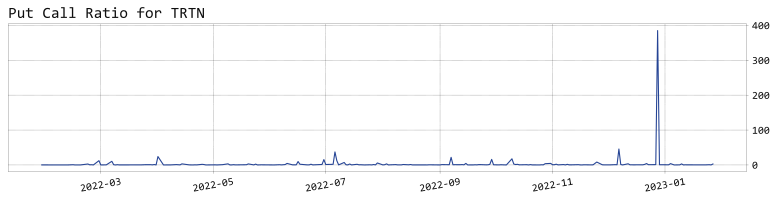

In [20]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [21]:
expiry_dates = openbb.stocks.options.expirations(symbol)
if (len(expiry_dates) > 0):
    exp = expiry_dates[0]
    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
else:
    option_chain = pd.DataFrame()


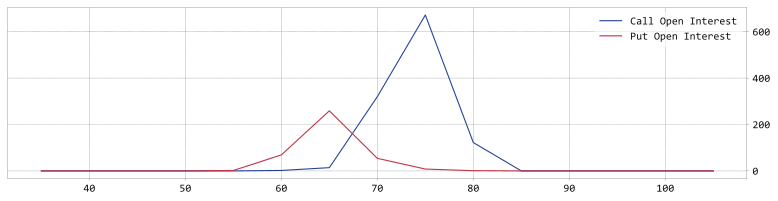

In [22]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    ax.plot(
        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
    )
    ax.plot(
        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
    )
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    vol_chart = f.getvalue().decode("utf-8")

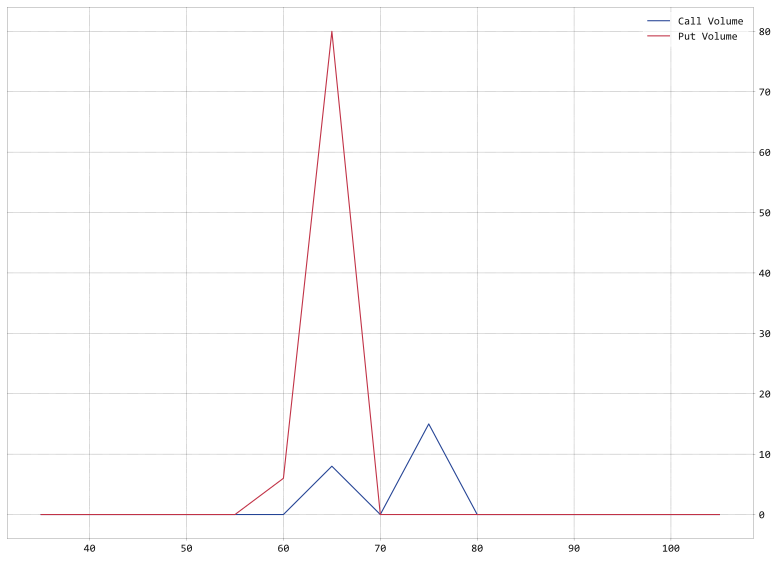

In [23]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    voi_chart = f.getvalue().decode("utf-8")

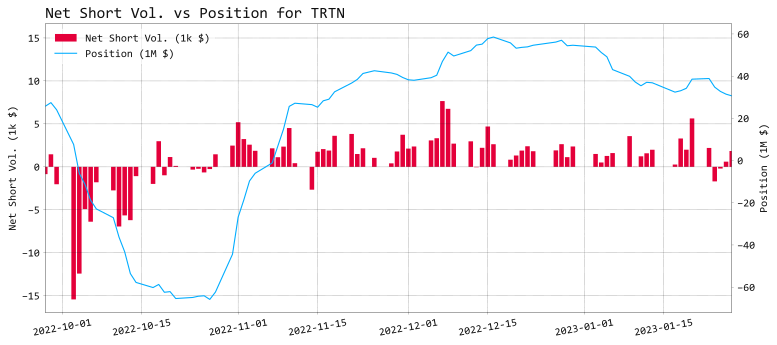

In [24]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

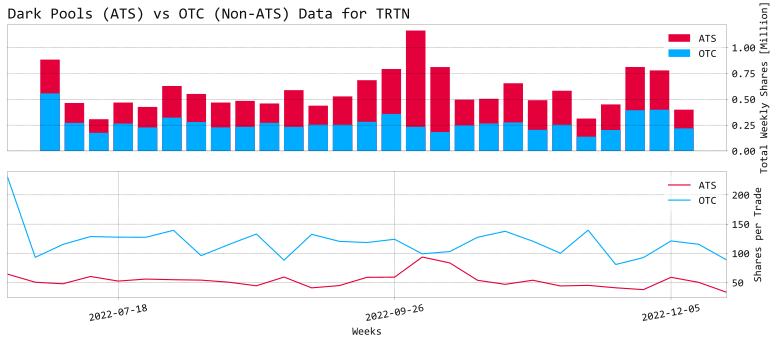

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No congress trading data found

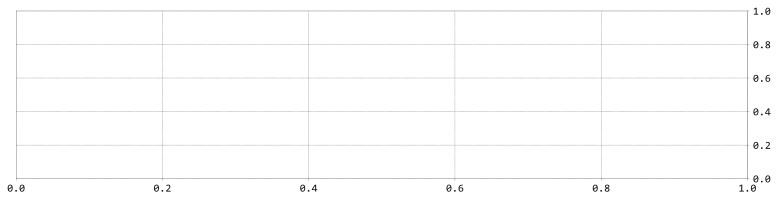

In [26]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

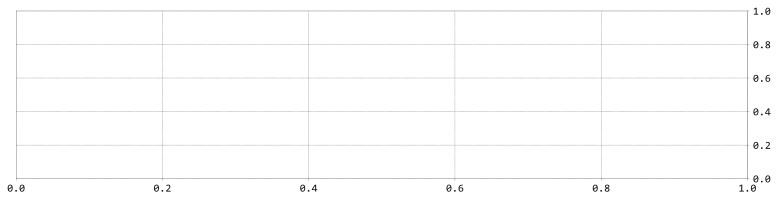

In [27]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

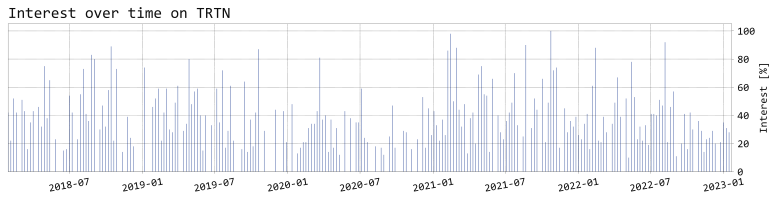

In [28]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

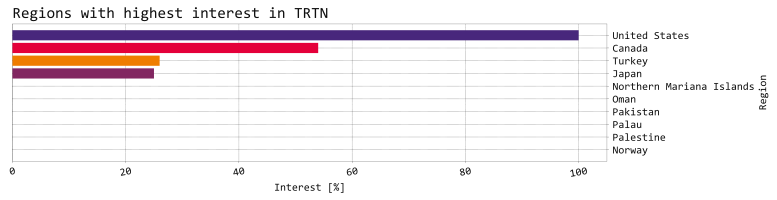

In [29]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

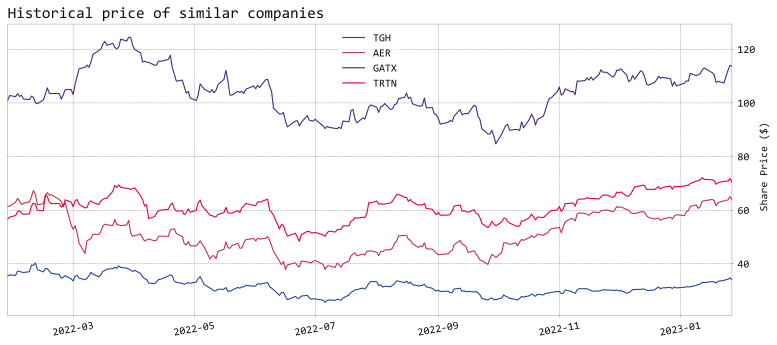

In [30]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

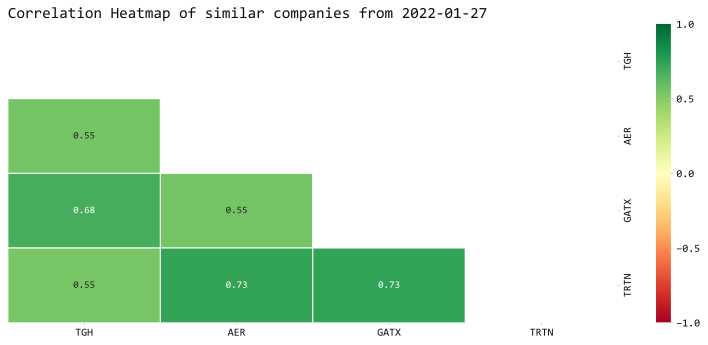

In [31]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

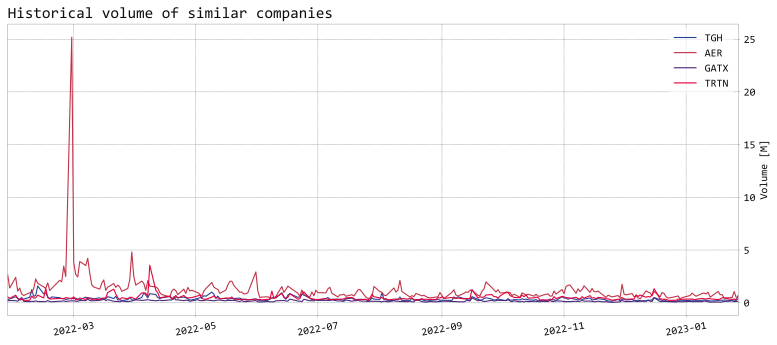

In [32]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

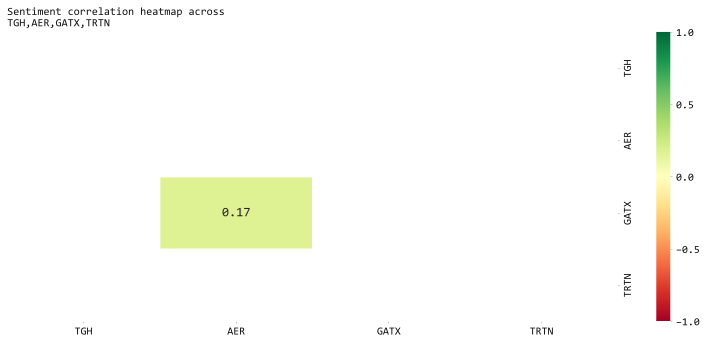

In [33]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [34]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,AER,$15980 M,nan,7.91,2.46,0.99,14.55,3.39,$3.87,$-0.03,$0.04
1,GATX,$4010 M,26.18,16.55,3.15,2.06,6.73,nan,$-0.06,$0.02,$-0.09
2,TGH,$1560 M,5.50,6.41,1.71,0.92,5.67,nan,$2.97,$-0.14,$0.51
3,TRTN,$4220 M,6.28,6.88,2.29,1.69,65.99,26.53,$0.74,$-0.09,$1.00


In [35]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,AER,nan%,-1.6%,-7.3%,3.2%,,,3.04,3.04,88.8%,0.9%,-17.4%
1,GATX,1.8%,1.8%,9.0%,3.1%,,,3.27,3.28,75.9%,24.8%,14.1%
2,TGH,0.7%,3.9%,18.9%,6.3%,1.2,1.2,3.13,3.37,89.5%,51.9%,32.9%
3,TRTN,4.0%,5.7%,29.1%,6.9%,,,3.26,3.26,90.5%,56.7%,39.0%


In [36]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,AER,240850000.0,239230000.0,0.0271,0.0000,,-0.0063,0.0140,3.88
1,GATX,35200000.0,34820000.0,0.0070,-0.0502,,0.0009,0.0595,16.22
2,TGH,45900000.0,41440000.0,0.7640,0.0000,0.727,0.0172,0.0449,6.94
3,TRTN,61030000.0,57540000.0,0.0219,0.0000,0.679,-0.0519,0.0315,4.16


In [37]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,AER,1.7%,11.4%,24.2%,43.0%,1.7%,9.6%,0.0194,0.0236,1.7
1,GATX,5.3%,4.3%,13.4%,14.3%,9.7%,7.0%,0.0233,0.0205,1.6
2,TGH,1.6%,9.1%,16.2%,2.3%,-6.7%,9.7%,0.0193,0.0196,1.0
3,TRTN,0.3%,2.1%,18.9%,9.7%,18.0%,2.4%,0.0161,0.0163,2.5


In [38]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [39]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

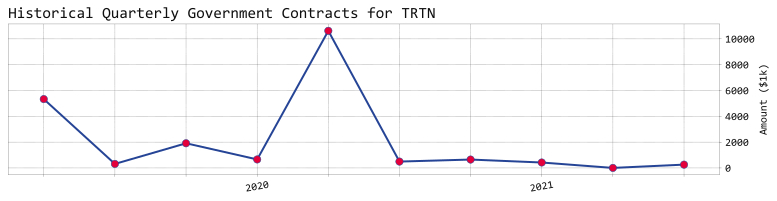

In [40]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [41]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


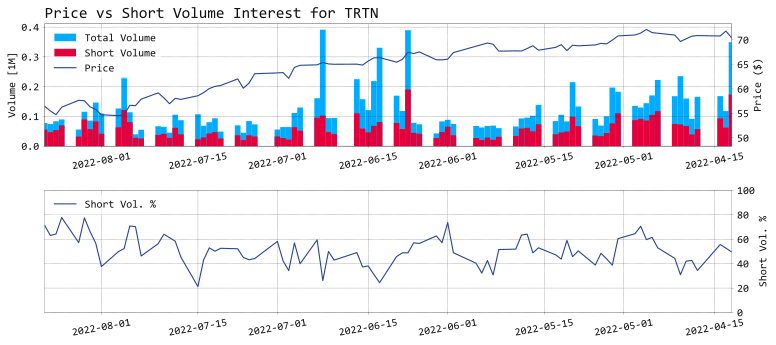

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

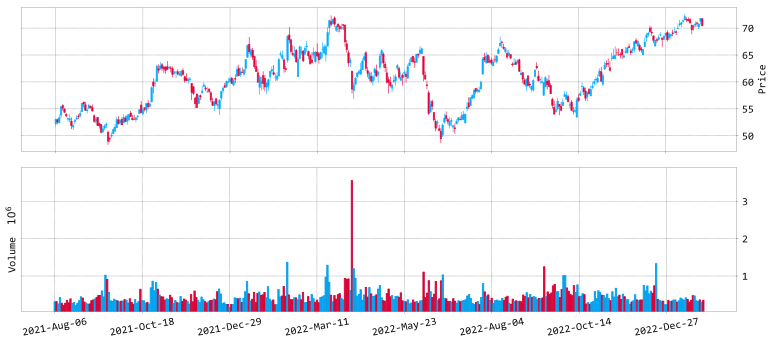

In [43]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

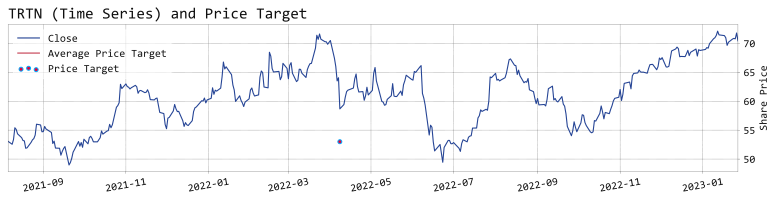

In [44]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [45]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

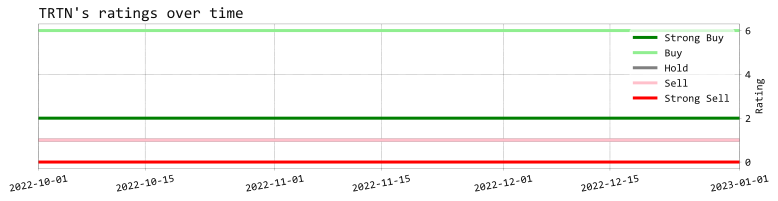

In [46]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

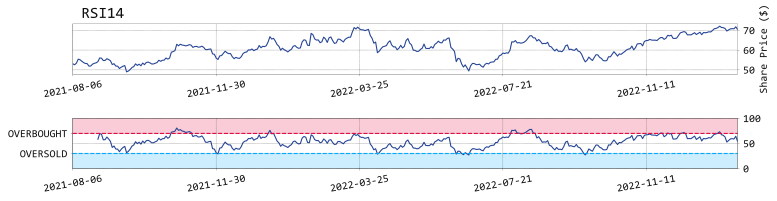

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [48]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

54.03

In [49]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [50]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

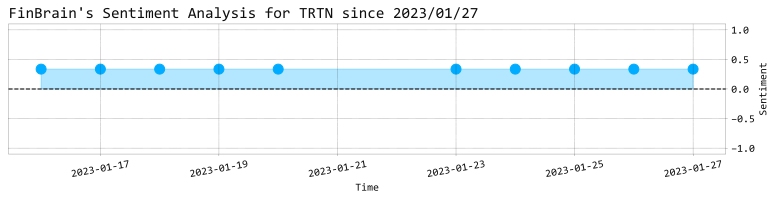

In [51]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [52]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [53]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 920</br>No messages found'

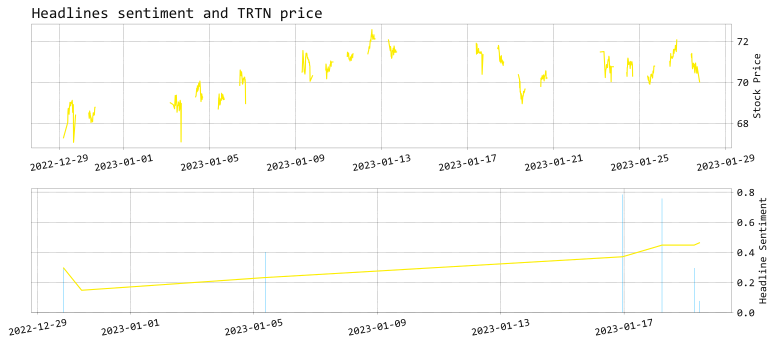

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [55]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for TRTN with starting period 2019-08-19.

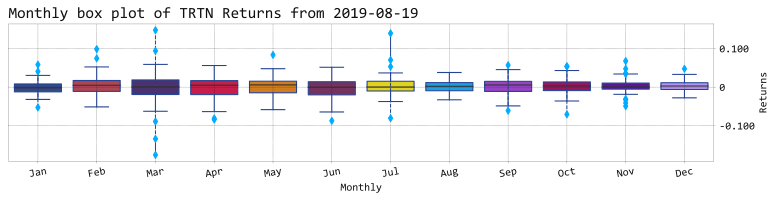

In [56]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

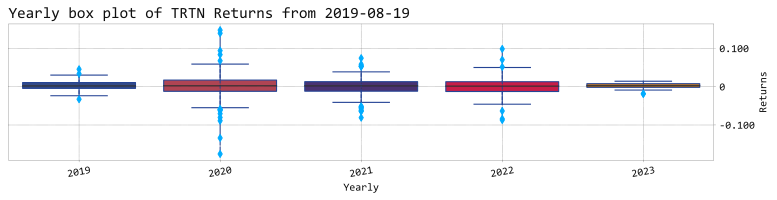

In [57]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [58]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for TRTN

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

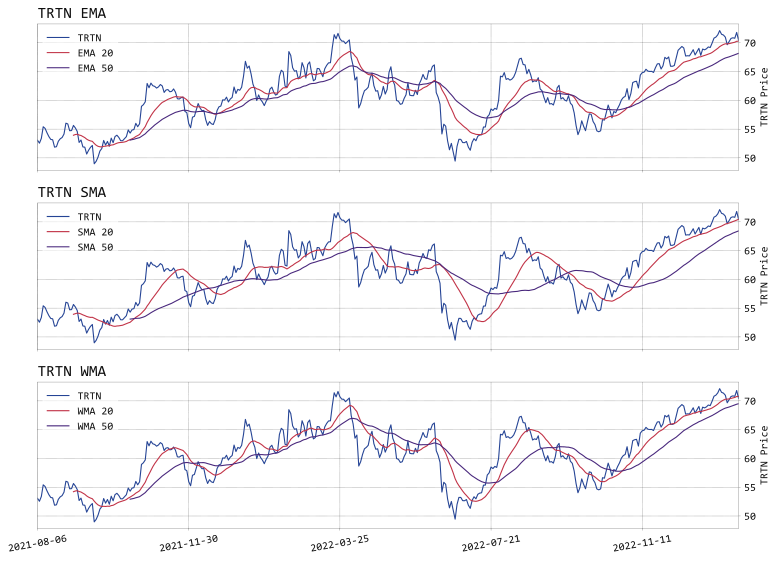

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

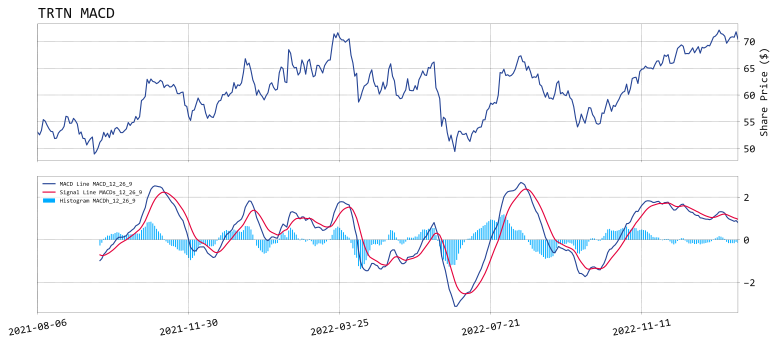

In [60]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

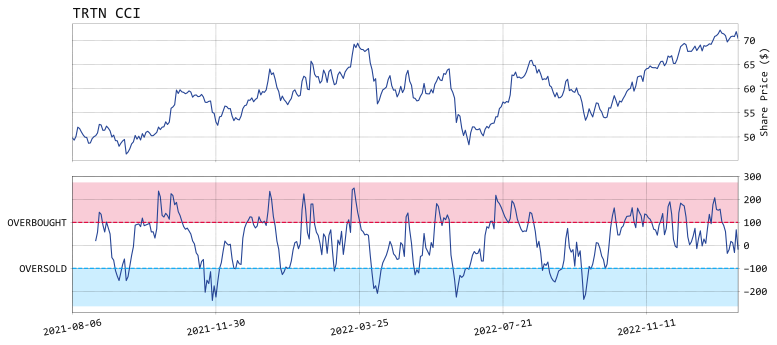

In [61]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

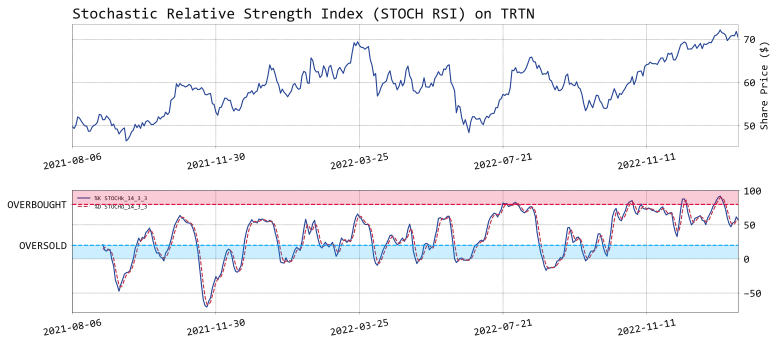

In [62]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

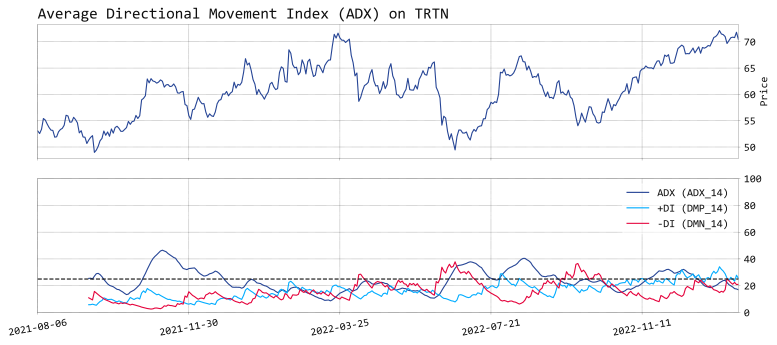

In [63]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

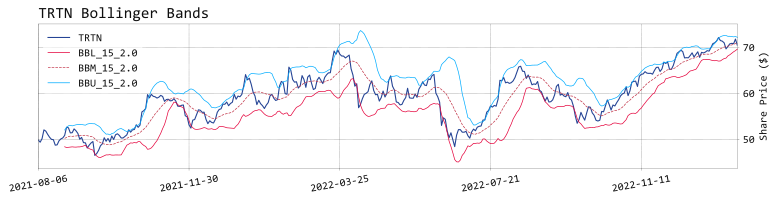

In [64]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

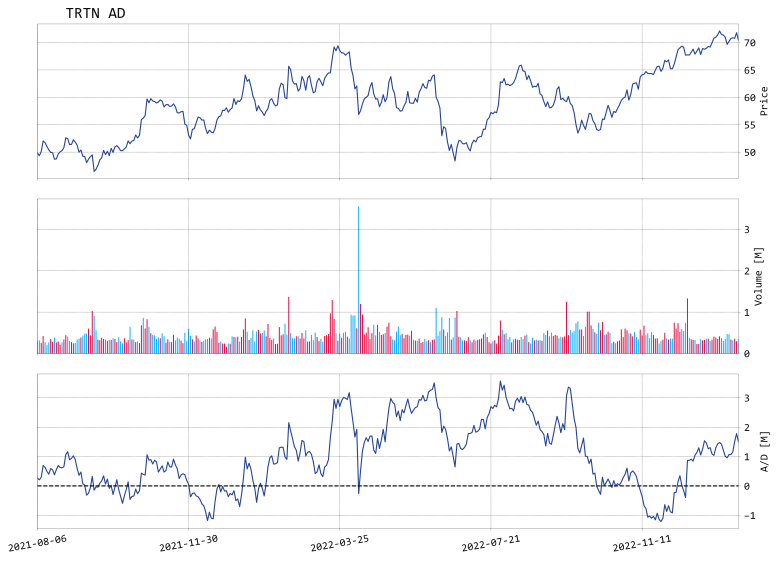

In [65]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [68]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                {{
                "width": "1085",
                "height": "500",
                "colorTheme": "light",
                "isTransparent": false,
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

body += widgets.add_tab("Summary", htmlcode, False)


htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)
htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass


body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
if not option_chain.empty:
    htmlcode += widgets.row(
        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
    )
    htmlcode += widgets.row(
        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
    )
try:
    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
except:
    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

#htmlcode = """
#   <iframe src="https://ycharts.com/companies/TRTN/chart/" width="1085" height="700"></iframe>
#        """
htmlcode = """
    <div class="iframely-embed"><div class="iframely-responsive" style="height: 140px; padding-bottom: 0;"><a href="https://seekingalpha.com/symbol/TRTN/peers/comparison" data-iframely-url="//cdn.iframe.ly/api/iframe?url=https%3A%2F%2Fseekingalpha.com%2Fsymbol%2FTRTN%2Fpeers%2Fcomparison%3Fcompare%3DTRTN%2CGATX%2CHRI%2CMSM%2CBECN%2CAL&key=a26e39d5d46d5d92044fbef9038730d6"></a></div></div><script async src="//cdn.iframe.ly/embed.js" charset="utf-8"></script>
    """
try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)


htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)